In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import statsmodels.api as sm

In [9]:
R_path = "/Users/pongpisitthanasutives/Desktop/research/R/python_data"
os.path.join(R_path, 'X_pre_burgers_noise50.npy')
X_pre = np.load(os.path.join(R_path, 'X_pre_burgers_noise50.npy'))
y_pre = np.load(os.path.join(R_path, 'y_pre_burgers_noise50.npy'))

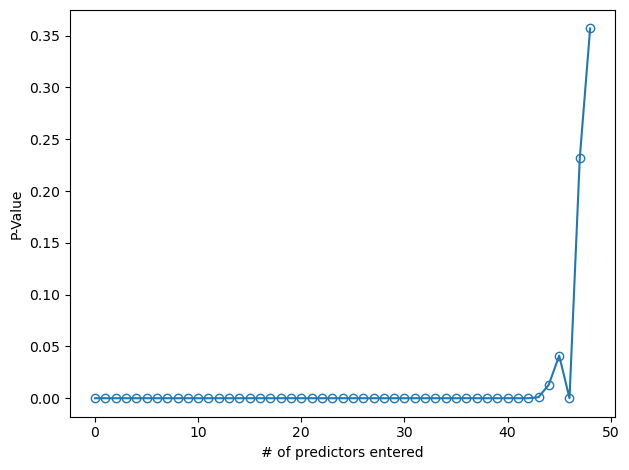

In [10]:
active_set = []
pvalues = []
X_sub = X_pre.copy()
nfeats = X_sub.shape[-1]
while len(active_set) < nfeats:
    possible_indices = [i for i in range(X_pre.shape[-1]) if i not in active_set]
    r2s = []
    fits = []
    for i in possible_indices:
        fit = sm.OLS(y_pre, X_pre[:, active_set+[i]]).fit()
        fits.append(fit)
        r2s.append(fit.rsquared)
    active_set.append(possible_indices[np.argmax(r2s)])
    # print(active_set)
    pvalues.append(fits[np.argmax(r2s)].pvalues[-1])
assert len(active_set) == nfeats
plt.plot(pvalues, '-o', markerfacecolor='none')
plt.ylabel("P-Value")
plt.xlabel("# of predictors entered")
plt.tight_layout()
plt.show()